In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GB, 
    GradientBoostingClassifier as GC)
from ISLP.bart import BART
import sklearn.model_selection as skm
import seaborn as sns
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import networkx as nx
import graphviz
from networkx.drawing.nx_agraph import graphviz_layout

In [2]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

In [7]:
df = pd.read_pickle("data.pkl")

## DAG PLOT

In [4]:
### MAIN DAG ###
dag4 = """
graph [
  node [ id 0 label "Controls" ]
  node [ id 1 label "FemaleType" ]
  node [ id 2 label "PublicFacing" ]
  node [ id 3 label "Callback" ]

  edge [ source 0 target 3 ]
  edge [ source 1 target 3 ]
  edge [ source 2 target 3 ]
]
"""



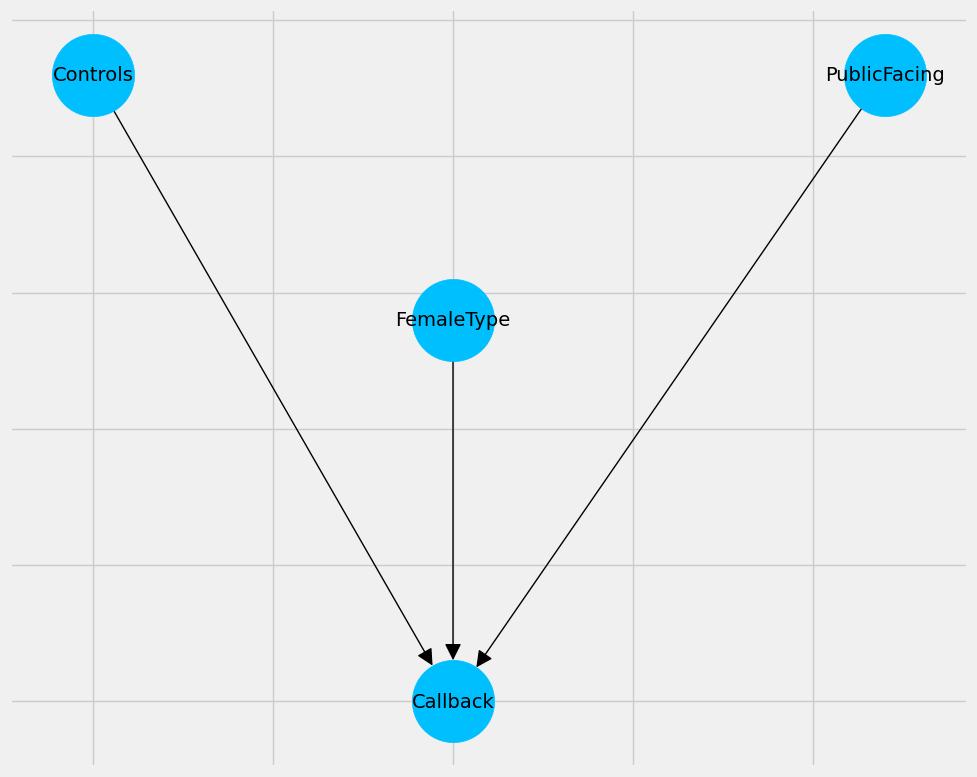

In [5]:
#### PRINT THE DAG PLOT ####
graph4 = nx.parse_gml(dag4)

pos4 = {
    "Controls": (-1, 2.3), 
    "PublicFacing": (1.2, 2.3),
    "FemaleType": (0, 1.4),
    "Callback": (0, 0)
}

plt.figure(figsize=(10, 8))
nx.draw_networkx(
    graph4,
    pos4,
    with_labels=True,
    node_size=3500,
    node_color='deepskyblue',
    font_color='black',
    font_size=14,
    arrows=True,
    arrowsize=25,
    arrowstyle='-|>'
)
plt.tight_layout()
plt.savefig("DAG4.png", dpi=300)
plt.show()


## DAG LOGIT AND TEST WITH 3-WAY INTERACTION

In [12]:
## Create interaction terms
for i in range(1, 5):
    df[f"type_{i}_female_public"] = (
        df[f"type_{i}"] * df["female"] * df["public_facing"])
    df[f"type_{i}_female"] = (
        df[f"type_{i}"] * df["female"])
    
df["female_public"] = (df["female"] * df["public_facing"])

# List of triple interactions
triple_interactions = [
    "type_1_female_public",
    "type_2_female_public",
    "type_3_female_public",
    "type_4_female_public"
]

#### LOGIT FOR DAG WITH TRIPLE INTERACTIONS ####
# Outcome
y = df["callback"]

# Contain regressors that are important, no need to control for covariates because of DAG
X_vars = ["type_1_female_public", "type_2_female_public", "type_3_female_public", "type_4_female_public"]


# Full sample logit
X_full = sm.add_constant(df[X_vars])
model_full = sm.Logit(y, X_full).fit(disp=0)

# Subset refutation logit
subset = df.sample(frac=0.4, random_state=1)
X_sub = sm.add_constant(subset[X_vars])
y_sub = subset["callback"]
model_sub = sm.Logit(y_sub, X_sub).fit(disp=0)

# Prepare table with Logit and AME
rows = []
for t in triple_interactions:
    rows.append({
        "Treatment": t,
        "Full coef": model_full.params[t],
        "Full SE": model_full.bse[t],
        "Full p-val": model_full.pvalues[t],
        "Subset coef": model_sub.params[t],
        "Subset SE": model_sub.bse[t],
        "Subset p-val": model_sub.pvalues[t],
    })

# Convert to DataFrame
table = pd.DataFrame(rows)

print(
    table.to_latex(
        index=False,
        escape=False,
        caption="DAG Logit and Refutation Test",
        label="daglogit",
        float_format="%.3f"
    )
)

\begin{table}
\caption{DAG Logit and Refutation Test}
\label{daglogit}
\begin{tabular}{lrrrrrr}
\toprule
Treatment & Full coef & Full SE & Full p-val & Subset coef & Subset SE & Subset p-val \\
\midrule
type_1_female_public & 0.313 & 0.105 & 0.003 & 0.307 & 0.165 & 0.062 \\
type_2_female_public & 0.304 & 0.134 & 0.023 & 0.357 & 0.213 & 0.095 \\
type_3_female_public & 0.038 & 0.153 & 0.805 & 0.076 & 0.237 & 0.747 \\
type_4_female_public & -0.250 & 0.168 & 0.136 & -0.137 & 0.246 & 0.577 \\
\bottomrule
\end{tabular}
\end{table}



## DAG AND LOGIT FOR TWO-WAY INTERACTION 

In [15]:
#### LOGIT FOR MODEL WITH TWO-WAY INTERACTIONS ONLY ####
# Outcome
y = df["callback"]

# Contain regressors that are important, no need to control for covariates because of DAG
X_vars = ["type_1_female", "type_2_female", "type_3_female", "type_4_female"]
two_way_interactions = ["type_1_female", "type_2_female", "type_3_female", "type_4_female"]

# Full sample logit
X_full = sm.add_constant(df[X_vars])
model_full = sm.Logit(y, X_full).fit(disp=0)

# Subset refutation logit
subset = df.sample(frac=0.4, random_state=1)
X_sub = sm.add_constant(subset[X_vars])
y_sub = subset["callback"]
model_sub = sm.Logit(y_sub, X_sub).fit(disp=0)

# Prepare table with Logit and AME
rows = []
for t in two_way_interactions:
    rows.append({
        "Treatment": t,
        "Full coef": model_full.params[t],
        "Full SE": model_full.bse[t],
        "Full p-val": model_full.pvalues[t],
        "Subset coef": model_sub.params[t],
        "Subset SE": model_sub.bse[t],
        "Subset p-val": model_sub.pvalues[t],
    })

# Convert to DataFrame
table2 = pd.DataFrame(rows)

print(
    table2.to_latex(
        index=False,
        escape=False,
        caption="DAG Logit and Refutation Test, Two-Way Interactions",
        label="daglogit",
        float_format="%.3f"
    )
)

\begin{table}
\caption{DAG Logit and Refutation Test, Two-Way Interactions}
\label{daglogit}
\begin{tabular}{lrrrrrr}
\toprule
Treatment & Full coef & Full SE & Full p-val & Subset coef & Subset SE & Subset p-val \\
\midrule
type_1_female & 0.026 & 0.084 & 0.753 & -0.031 & 0.135 & 0.816 \\
type_2_female & -0.030 & 0.105 & 0.771 & 0.004 & 0.165 & 0.982 \\
type_3_female & -0.261 & 0.120 & 0.030 & -0.104 & 0.176 & 0.553 \\
type_4_female & -0.543 & 0.133 & 0.000 & -0.576 & 0.207 & 0.005 \\
\bottomrule
\end{tabular}
\end{table}

